In [12]:
# CapacitorPlates
# Program using the relaxation method with a 3D rectangular lattice to test
# the validity of common approximations for the electrostatic potential between
# the two rectangular plates of a parallel plate capacitor.
# made by Masen Pitts
# Updated 11/30/2021

import numpy as np

# Addressing Possible Ambiguities in Comments:
# - "Boundary of the region" refers to the actual ends of the 3D mesh grid
# and not the points within the region that are given pre-determined values.
# - "Not Free Points" refers to points both on the boundary and within the boundary
# at which the value of the potential is pre-determined.
# - Units: The units of distance are meters and the units of potential are volts.

meshResolution = 100 # Gives the number of mesh points extending in each direction;
                    # each spatial axis has points defined on [0, meshResolution]
                    # (unless it is indicated otherwise)
 
# Function that sets the potential value of the mesh points on the boundary of the region and marks them
# as not free.
# Expected Parameters:
#   potential - A 3D NumPy Array of floating point values
#   freePoints - A 3D NumPy Array of boolean values
#   boundaryValue - A floating point or integer value specifying the desired value
#                   of the potential at the boundary of the region
#**NOTE: This function expects "potential" and "freePoints" to be the same shape!**
def setBoundaries(potential, freePoints, boundaryValue):
    # Prints an error message and ends the program if the arrays passed to the function are not the same shape
    if potential.shape != freePoints.shape:
        print("Error: The array passed for the potential must be the same shape as the array passed for freePoints!")
        print("Check the shapes of the arrays being passed to the \"setBoundaries\" function")
        quit()   
    # Variables that store the values of the non-zero ends of the region boundary
    global xEnd, yEnd, zEnd
    xEnd = potential.shape[0]
    yEnd = potential.shape[1]
    zEnd = potential.shape[2]
    
    # Iterates through every mesh point on the boundary of the region, setting the potential
    # at these points equal to the given value and marking the points as not free
    for y in range(yEnd):
        for z in range(zEnd):
            potential[0, y, z] = boundaryValue
            potential[xEnd-1, y, z] = boundaryValue
            freePoints[0, y, z] = False
            freePoints[xEnd-1, y, z] = False
    for x in range(xEnd):
        for z in range(zEnd):
            potential[x, 0, z] = boundaryValue
            potential[x, yEnd-1, z] = boundaryValue
            freePoints[x, 0, z] = False
            freePoints[x, yEnd-1, z] = False
    for x in range(xEnd):
        for y in range(yEnd):
            potential[x, y, 0] = boundaryValue
            potential[x, y, zEnd-1] = boundaryValue
            freePoints[x, y, 0] = False
            freePoints[x, y, zEnd-1] = False

# Function that implements the relaxation method for a given 3D mesh grid to calculate the electrostatic
# potential at each free point on the grid.
# **NOTE: The function "setBoundaries" sets the values of global variables should always be run before 
#         used in "relaxation" and hence should always be run at least once before this function.
# Expected Parameters:
#   p - A 3D NumPy Array of floating point values representing the "potential" array
#   freePoints - A 3D NumPy Array of boolean values
#   tolerance - A floating point number that specifies how accurate the relaxation should
#               be and hence how long the method should run. The process will stop once the largest change
#               in a potential value between any two iterations is less than "tolerance."
#   relaxFactor - A floating point number or integer that allows for over-relaxation to be used 
#                 if desired. 
#                       relaxFactor = 1: Normal relaxation method implemented
#                       relaxFactor > 1: Over-relaxation occcurs
#                 Values between 1 and 2 should be used since a value of 2 or greater makes the method unstable. 
#                 Values in the range of 1.5-1.8 seem to be the fastest. This may change based on the value of 
#                 meshResolution and can vary with given problem conditions
def relaxation(p, freePoints, tolerance, relaxFactor):
    
    dVmax = 100 # Keeps track of the largest change in potential value between the previous iterations
                # and the current one.
    n=0 # Counts the total number of iterations the while loop makes (for use see commented out code below)
    while dVmax > tolerance:
        dVmax = 0
        for x in range(xEnd):
            for y in range(yEnd):
                for z in range(zEnd):
                    if freePoints[x, y, z]:
                        oldV = p[x, y, z] # Store the old potential value at this point
                        # Calculate the new potential at this point by taking the average of the potential
                        # values of all adjacent points.
                        newV = (1/6)*(p[x+1,y,z]+p[x-1,y,z]+p[x,y+1,z]+p[x,y-1,z]+p[x,y,z+1]+p[x,y,z-1])
                        dV = newV - oldV    # Store the change in potential value between iterations
                        # Checks for new dVmax
                        if abs(dV) > dVmax:
                            dVmax = abs(dV)
                        p[x, y, z] = oldV + dV*relaxFactor
        n+=1           # This commented out code can be used to test values of relaxFactor; the code will 
        print(dVmax)   # print the total number of times the relaxation method iterates and will print the
    print(n)           # value of dVmax calculated during each iteration. Printing the value of dVmax allows
                       # the user to determine whether the algorithm is converging.


# Variables that determine the physical size of the rectangular bounds of the region
# in meters
xSize = 10
ySize = xSize
zSize = xSize

# Variables stored for convience for initializing the arrays and performing
# iterative calculations on the mesh points
xMesh = meshResolution + 1
yMesh = xMesh
zMesh = xMesh

# Variable that stores the physical space between each of the mesh points
d = ySize/meshResolution

# Initializes a 3D NumPy array of float values with a shape determined by the x/y/zMesh variables;
# Used to store calculated values of the electrostatic potential in Volts at each mesh point. Fill the array
# with 1 if you plan on populating the grid with a guess of the analytical solution. Otherwise
# fill it with 0.
potential = np.full((xMesh, yMesh, zMesh), 0, dtype=np.float64)

# Initializes a 3D NumPy array of boolean values with the same shape as the "potential" array;
# Used to determine which mesh points are "free." Free mesh points are points where the potential
# is to be determined. Points that are not free are those that are given fixed values in the set-up
# of the model.
freePoints = np.full((xMesh, yMesh, zMesh), True, dtype=np.bool_)

plateX = 5 # Variables that determine the length and width of the plate in meters
plateY = 5 #
dPlates = 1.0 # Determines the seperation distance between the plates
plateV = 1.0 # Determines the potential value on the positive plate. The negative plate will have the
            # negative of this value.

# Sets the boundaries of the region to the constant value V = 0
setBoundaries(potential, freePoints, 0)

# Variables used to set the potential values of the plates and graph the data
meshMid = int(xSize/(2*d))
meshZd = int(dPlates/(2*d))
meshXd = int(plateX/(2*d))
meshYd = int(plateY/(2*d))

# Sets the potential values of both plates and marks their mesh points as not free
for x in range(meshMid-meshXd, meshMid+meshXd+1):
    for y in range(meshMid-meshYd, meshMid+meshYd+1):
        potential[x, y, meshMid+meshZd] = plateV
        freePoints[x, y, meshMid+meshZd] = False
        potential[x, y, meshMid-meshZd] = -plateV
        freePoints[x, y, meshMid-meshZd] = False
        
# Implements the relaxation method for the region that has been set up
relaxation(potential, freePoints, 0.0001, 1.8)

0.416666654910175
0.34930145815513197
0.2560378370073604
0.17577851787871523
0.13182836946469856
0.09885950409829371
0.0741228865412856
0.05555647179501895
0.041614258731756656
0.03113809832547488
0.023261325537703118
0.019708946934776178
0.016279112163382403
0.013853999355718016
0.01301043687311465
0.011353487862974687
0.01060703362362908
0.009416282320499403
0.008585848931981999
0.0075263210083965915
0.006570073732638654
0.005809556451329384
0.005077741058197777
0.004448750830858689
0.003883435691270448
0.0033196666159719668
0.002863159843357721
0.0024766087463782283
0.0021422280996718224
0.0018630953226201341
0.0016191750420104511
0.00141342464067587
0.0012388602467229837
0.001074965086998031
0.000927713951040493
0.0008114661966681924
0.0006975891568641868
0.0005924548960644371
0.0005084044864422377
0.000427525732987738
0.000366390390978133
0.00032741882172512837
0.0002781129147969158
0.00024192843786494111
0.00020623743303825604
0.00017580764071302435
0.00015019468503044142
0.00013

<IPython.core.display.Javascript object>


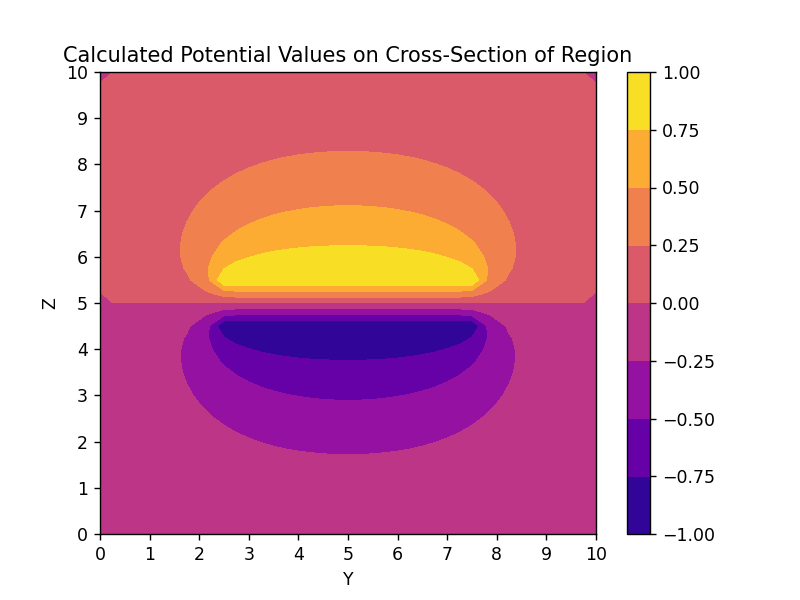

interactive(children=(IntSlider(value=20, continuous_update=False, description='Mesh X', max=40), Output()), _…

<IPython.core.display.Javascript object>


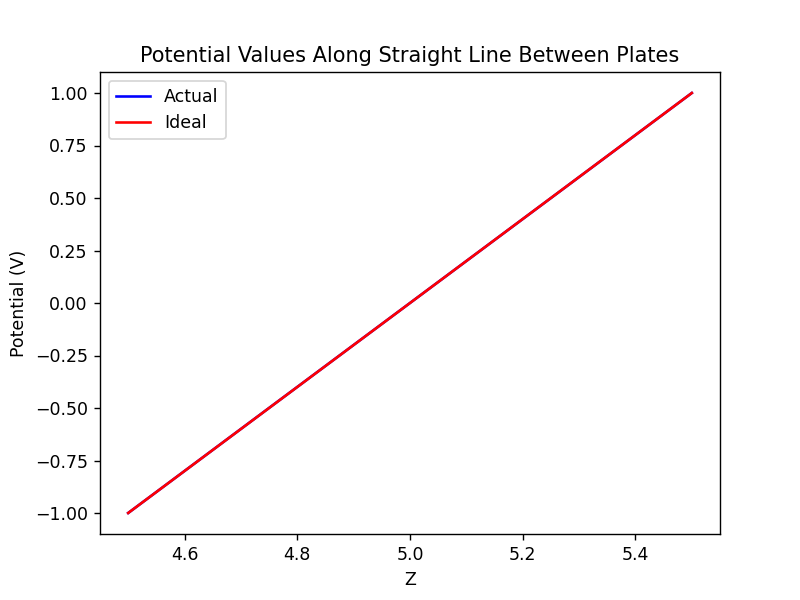

interactive(children=(IntSlider(value=20, continuous_update=False, description='Mesh Y', max=30, min=10), Outp…

<function __main__.updateLine(slider)>

In [13]:
%matplotlib notebook
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm

# Slider that controls the x-position of the cross-section
crossSlider = widgets.IntSlider(value=meshMid, min=0, max=xMesh-1, step=1, description="Mesh X", continuous_update=False)

# Slider that controls the y-position of the straight line parallel to the z-axis connecting
# the plates
lineSlider = widgets.IntSlider(value=meshMid, min=meshMid-meshYd, max=meshMid+meshYd, step=1, 
                               description="Mesh Y", continuous_update=False)

# Create lists representing the physical y and z positions of the cross-section points
y = np.linspace(0, ySize, yMesh)
z = np.linspace(0, zSize, zMesh)

cross = plt.figure("X-Cross Sections") # Figure used for the contour plot of the cross-section

def updateCross(slider):
    # Switch current figure to cross section one
    plt.figure("X-Cross Sections")
    cross.clear() # Clear the plot
    # Set graph attributes
    plt.title("Calculated Potential Values on Cross-Section of Region")
    plt.xlabel("Y")
    plt.ylabel("Z")
    plt.xticks(range(0, ySize+1, int(ySize/10)))
    plt.yticks(range(0, zSize+1, int(zSize/10)))
    # Plot data using the value of the slider to choose the cross-section
    plt.contourf(y, z, potential[slider].T, cmap=cm.plasma)
    plt.colorbar()
    plt.show()
    print("X = {:.2f}".format(slider*d)) # Prints X-Position in physical space

# Create a widget that allows the contour plot to be updated by crossSlider
widgets.interact(updateCross, slider=crossSlider)

line = plt.figure("Y-Line Slices") # Figure used for plotting potential values on line slice
    
def updateLine(slider):
    X = crossSlider.value # Stores mesh x-position
    Z = np.linspace((zSize-dPlates)/2, (zSize+dPlates)/2, 2*meshZd+1) # List representing the physical z positions
                                                                      # of the points along the line
    V = np.linspace(-1.0, 1.0, 2*meshZd+1) # List representing the ideal values of the potential between the plates
    # Switch current figure to the one for line slices
    plt.figure("Y-Line Slices")
    line.clear() # Clear the plot
    # Set graph attributes
    plt.title("Potential Values Along Straight Line Between Plates")
    plt.xlabel("Z")
    plt.ylabel("Potential (V)")
    # Plot the potential values calculated by the relaxation method
    plt.plot(Z, potential[X, slider, meshMid-meshZd:meshMid+meshZd+1], color="blue", label="Actual")
    # Sets the ideal potential values to zero if the cross section is outside of the plates;
    # otherwise plots the potential as linearly increasing from one plate to the other
    if X*d > (xSize+plateX)/2 or X*d < (xSize-plateX)/2:
        plt.plot(Z, np.zeros(2*meshZd+1), color="red", label="Ideal")
    else:
        plt.plot(Z, V, color="red", label="Ideal")
    plt.legend()
    plt.show()
    print("Y = {:.2f}".format(slider*d)) # Prints Y-Position in physical space

# Create a widget that allows the line slice plot to be updated by lineSlider
widgets.interact(updateLine, slider=lineSlider)

#print(potential[meshMid, meshMid])